In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import sys
sys.path.append("../")

from datasets.FreiHAND import FreiHAND

from config import *

import albumentations as A
import cv2
from PIL import Image

CROP_HEIGHT = 200
RANDOM_CROP_SIZE = 180

In [2]:
config = {
    "data_dir": "/data/wmucha/datasets/FreiHAND",
    "model_path": "/caa/Homes01/wmucha/repos/applied_deep_learning/applied_dl/saved_models/fulldata_aug2_53",
    "test_batch_size": 32,
    "device": 3
}

In [3]:
img_transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.RandomRotation(degrees=(0, 30)),
                    transforms.RandomCrop(RANDOM_CROP_SIZE),
                    transforms.Resize(MODEL_IMG_SIZE),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    # transforms.Normalize(mean=TRAIN_DATASET_MEANS, std=TRAIN_DATASET_STDS),
                ]
            )

heatmap_transform = transforms.Compose(
                [
          
                    transforms.RandomRotation(degrees=(0, 30)),
                    transforms.RandomCrop(RANDOM_CROP_SIZE),
                    transforms.Resize(MODEL_IMG_SIZE),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                  
                ]
            )

test_dataset = FreiHAND(config=config, set_type="train", img_transform= img_transform, heatmap_transform = heatmap_transform)
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)




Number of train samples: 130240


In [22]:
img_transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    # transforms.RandomRotation(degrees=(0, 30)),
                    # transforms.RandomCrop(RANDOM_CROP_SIZE),
                    transforms.Resize(MODEL_IMG_SIZE),
                    # transforms.RandomHorizontalFlip(p=1),
                    # transforms.RandomVerticalFlip(p=1),
                    RandomNoise(),
                    transforms.GaussianBlur(3),
                    # transforms.Normalize(mean=TRAIN_DATASET_MEANS, std=TRAIN_DATASET_STDS),
                ]
            )

heatmap_transform = transforms.Compose(
                [
          
                    transforms.RandomRotation(degrees=(0, 30)),
                    transforms.RandomCrop(RANDOM_CROP_SIZE),
                    transforms.Resize(MODEL_IMG_SIZE),
                    transforms.RandomHorizontalFlip(p=1),
                    transforms.RandomVerticalFlip(p=1),
                  
                ]
            )

test_datasetrot = FreiHAND(config=config, set_type="train", img_transform= img_transform )
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

Number of train samples: 130240


In [23]:
def cv_to_pil(cv_image):
    cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(cv_image)
    return pil_image

In [24]:
def heatmaps_to_coordinates(heatmaps):
    """
    Heatmaps is a numpy array
    Its size - (batch_size, n_keypoints, img_size, img_size)
    """
#     print(heatmaps.shape)
#     if heatmaps.shape == (21,128,128):
#          batch_size = 1
    batch_size = heatmaps.shape[0]
    
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])
    normalized = heatmaps / sums
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, 21, 1])
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)
    keypoints = np.stack([x, y], axis=-1)
    return keypoints

In [25]:
def show_data(dataset, n_samples=1):
    """
    Function to visualize data
    Input: torch.utils.data.Dataset
    """
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    # ids = [2305]
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        image = sample["image"]
        transform = transforms.ToPILImage()
        image = transform(image)
        # print(image)
        # print(type(image))
        # image = np.moveaxis(image, 0, -1)
       
        # image = cv_to_pil(image)
        
        heatmaps = sample["heatmaps"]
        print(heatmaps.shape)
        heatmaps=heatmaps.resize(1,21,MODEL_IMG_SIZE,MODEL_IMG_SIZE)
        # print(heatmaps.shape)
        keypoints = heatmaps_to_coordinates(np.array(heatmaps))
       
        # keypoints = sample["keypoints"]
        keypoints = keypoints[0] #* MODEL_IMG_SIZE
        # print(keypoints)


        plt.subplot(n_rows, n_cols, i)
        # plt.imshow(  image.permute(1, 2, 0)  )
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()

In [26]:
%matplotlib widget

torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])


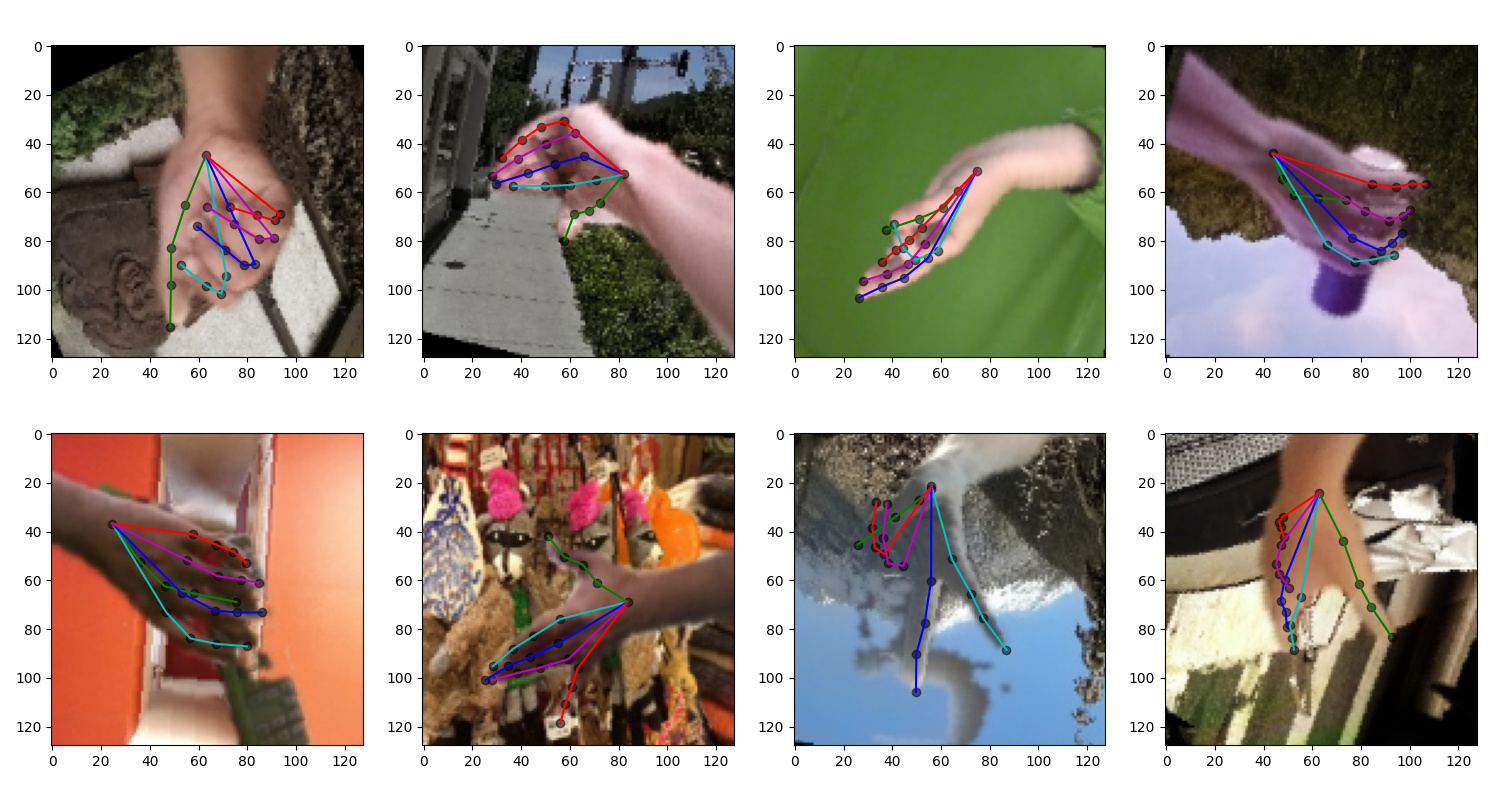

In [27]:
show_data(test_dataset, n_samples=8)

torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])
torch.Size([21, 128, 128])


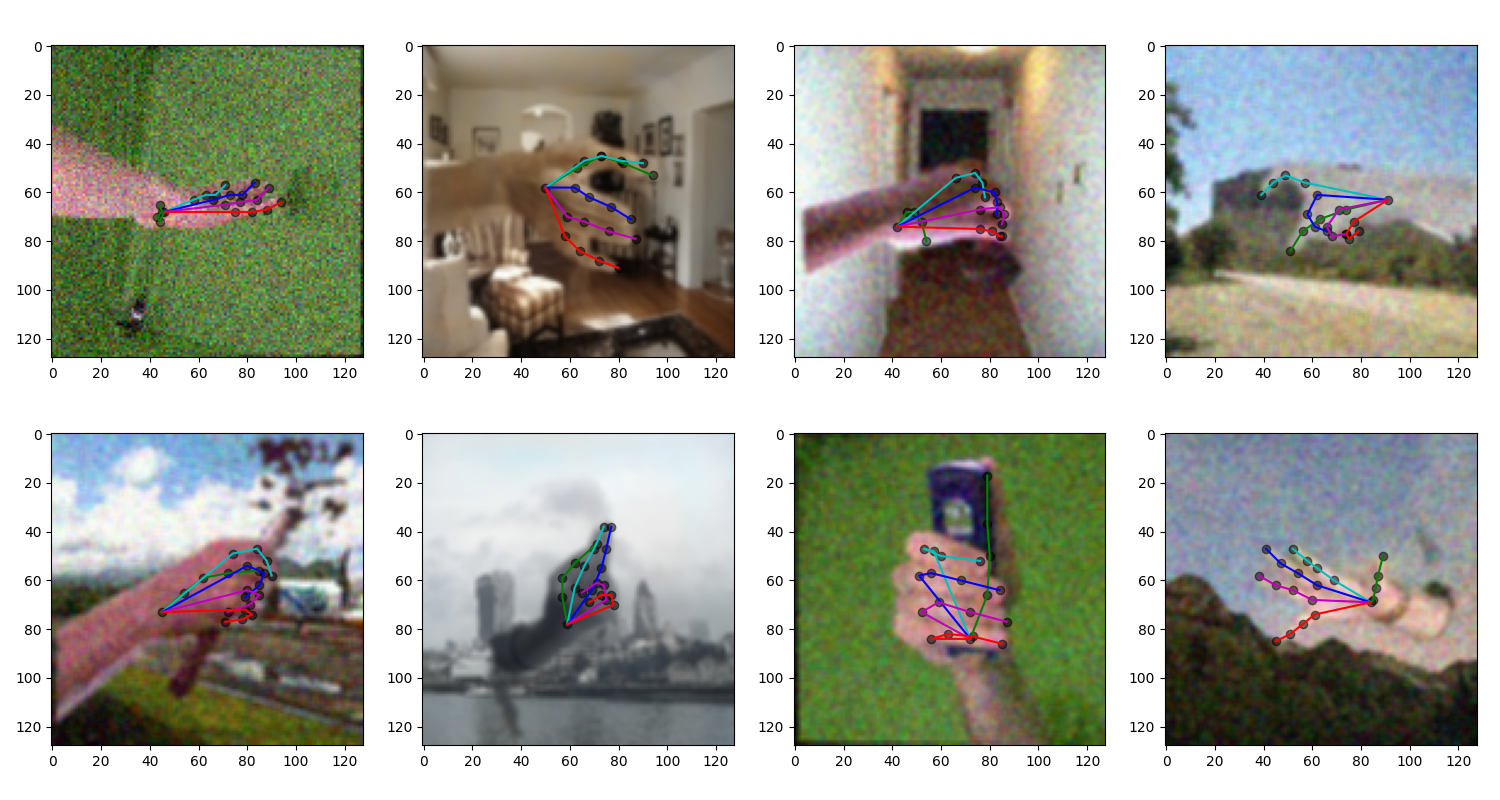

In [28]:
show_data(test_datasetrot, n_samples=8)